In [ ]:
%load_ext nb_black
%matplot

In [1]:
import os

import clickhouse_connect
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv


#load env file
load_dotenv("../notebooks/dev.env")
con = clickhouse_connect.get_client(
    interface="https",
    user=os.getenv("userOHSOME"),
    host=os.getenv("hostOHSOME"),
    password=os.getenv("pwOHSOME"),
    port=os.getenv("portOHSOME"))


# Filtering for hashtags
## Overview of contributions made to a hashtag
The following query gives an overview of the contributions made to a specified hashtag in a given timerange. These include the number of contributions, the number of distinct users and the modifications made building and highway features.

In [16]:
hashtag = "#missingmaps"

sql = f"""
    SELECT
    count(DISTINCT user_id) as users,
    count(DISTINCT contrib_id_text) as contributions,
    SUM(CASE WHEN (building_area > 0.0 ) THEN 1 ELSE 0 END) as building_edits,
    SUM(CASE WHEN (road_length > 0.0) THEN 1 ELSE 0 END) as road_edits
    FROM stats_2
    WHERE lower(hashtag) LIKE lower('{hashtag}')
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31')
"""
df = con.query_df(sql)

display(df.head(5))


,users,contributions,building_edits,road_edits
0,28385,22191022,18633084,1619277


## Stats accumulated by timestamp
In addition to the previous query, the stats can be aggregated by defined time intervals. The follwing query calculates number of contributions, the number of distinct users and the modifications made building and highway features for monthly timeintervals

,users,changesets,contributions,building_edits,road_edits
date,,,,,
2017-01-01,1930,59818,1281541,1053384,125407
2017-02-01,2659,87093,1328880,1044290,139403
2017-03-01,3747,102904,1479289,1139680,142998
2017-04-01,2854,181338,2360697,2099073,96869
2017-05-01,2568,123527,1955064,1777178,78582


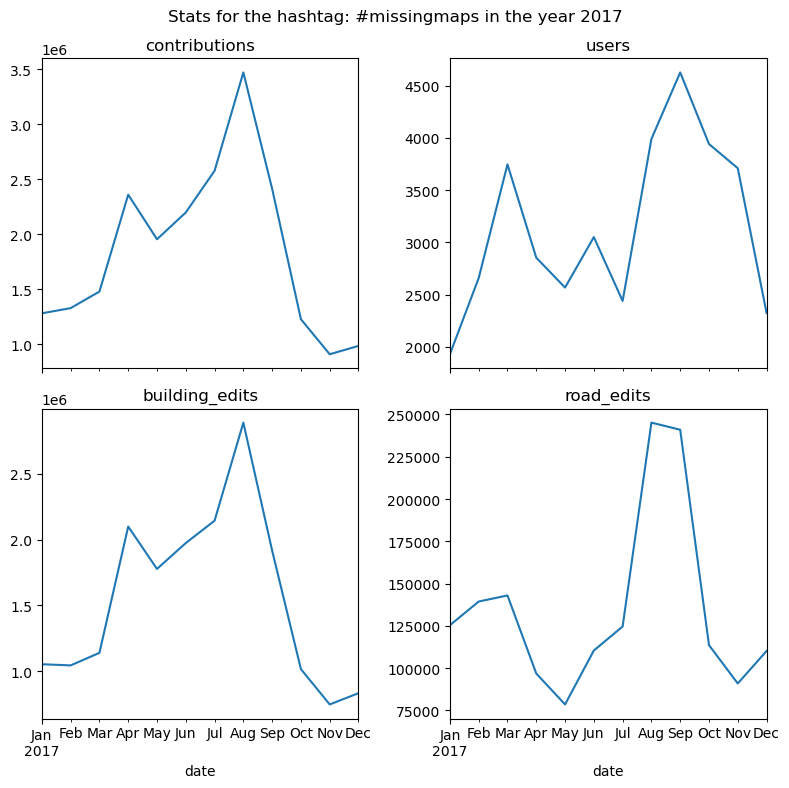

In [22]:
hashtag = "#missingmaps"

sql = f"""
    SELECT
    toYear(
        fromUnixTimestamp((changeset_timestamp/1000)::integer)
    ) as year,
    toMonth(
        fromUnixTimestamp((changeset_timestamp/1000)::integer)
    ) as month,
    count(DISTINCT user_id) as users,
    count(DISTINCT changeset_id) as changesets,
    count(DISTINCT contrib_id_text) as contributions,
    SUM(CASE WHEN (building_area > 0.0 ) THEN 1 ELSE 0 END) as building_edits,
    SUM(CASE WHEN (road_length > 0.0) THEN 1 ELSE 0 END) as road_edits
    FROM stats_2
    WHERE lower(hashtag) LIKE lower('{hashtag}')
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31')
    GROUP BY year, month
"""
# add subplots, user, contrib, buildings, roads
df = con.query_df(sql)
df["date"] = df.apply(
    lambda x: str(int(x.year)) + "-" + str(int(x.month)) + "-1", axis=1
)

df.date = pd.to_datetime(df.date)
df = df.set_index(pd.DatetimeIndex(df["date"])).drop(["year","month","date"],axis=1)

df = df.sort_index()

display(df.head(5))

fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(8,8))

for i, col in zip([(0,0),(0,1),(1,0),(1,1)],["contributions","users","building_edits","road_edits"]):
    ax = axs[i]
    df[col].plot(ax=ax)
    ax.set_title(col)
    ax.ylabel="date"
plt.suptitle("Stats for the hashtag: "+hashtag +" in the year 2017")
plt.tight_layout()
plt.show()

## Aggregation by User filterted for hashtags
The approach allows, to aggretate by userids. This allows to eg measure the number of contributions made by a individual user, or to examine how long a user contributed to a given hashtag (aka. survival rate of users)

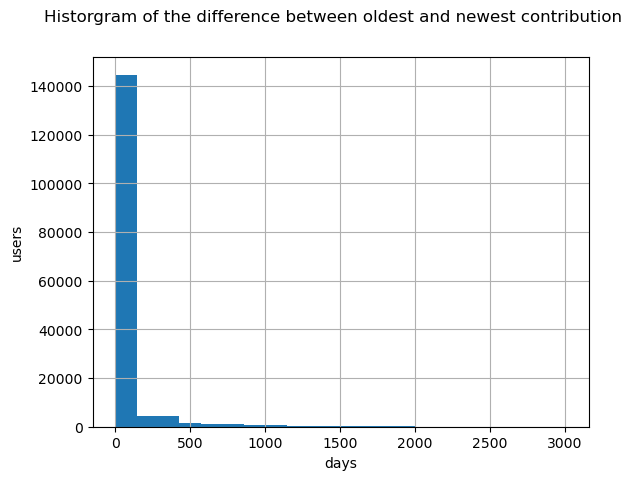

In [19]:
hashtag = "#MissingMaps"

sql = f"""
    SELECT user_id,
    count(DISTINCT contrib_id_text) as contributions,
    min(FROM_UNIXTIME((changeset_timestamp/1000)::integer)) as oldest,
    max(FROM_UNIXTIME((changeset_timestamp/1000)::integer)) as latest
    FROM stats_2
    WHERE lower(hashtag) ILIKE lower('{hashtag}')
    GROUP BY user_id
    """

df = con.query_df(sql)

df["delta"] = df.latest - df.oldest
df.delta = df.delta.dt.days
df.hist(column="delta",bins=21)
plt.suptitle("Historgram of the difference between oldest and newest contribution")
plt.title("")
plt.xlabel("days")
plt.ylabel("users")
plt.show()

# combination of hashtags
When calculate statistics for multiple hashtags, one has to differentiate between the two diffent logical operators "AND" and "OR". The following query show an example for the two hashatags #MissingMaps and #Bloomberg.
## OR combination

In [20]:
hashtags = ["#MissingMaps", "#bloomberg"]

sql = """
    SELECT count(*)
    FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY contrib_id_text ORDER BY osm_id DESC) AS rn
        FROM stats_2
        WHERE (
            ({})
            AND FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31'
            )
        )
    WHERE rn == 1
    """.format(' or '.join(['lower(hashtag) like lower(\'{}\')'.format(hashtag.replace("*", "%")) for hashtag in hashtags]))

df = con.query_df(sql)
display(df.head())


,count()
0,22191049


## And combinations

In [23]:
hashtags = ["#MissingMaps", "#bloomberg"]
sql = """
    SELECT count(*)
    FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY contrib_id_text ORDER BY osm_id DESC) AS rn
        FROM stats_2
        WHERE (
            ({})
            AND FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31'
            )
        )
    WHERE rn == {}
    """.format(' or '.join(['lower(hashtag) like lower(\'{}\')'.format(hashtag.replace("*", "%")) for hashtag in hashtags]),len(hashtags))

df = con.query_df(sql)
display(df.head(5))

,count()
0,40838


# Stats for countries
## Hashtags with most contributions in a country
The follwing query shows the most used hashtags by number of contributions in a given country (here: Uganda)

In [28]:
sql = """
    SELECT lower(hashtag) as hashtag_lower,
    count( DISTINCT changeset_id) as contributions
    FROM __stats_all_unnested
    WHERE has(country_iso_a3, 'UGA')
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31')
    GROUP BY hashtag_lower
    ORDER BY contributions DESC
    """

df = con.query_df(sql)

display(df.head(5))

,hashtag_lower,contributions
0,#mapgive,19749
1,#youthmappers,16350
2,#missingmaps,14325
3,#smgl,9964
4,#hotosm-project-3732,7756


# Differentiation contritubtions into creation, modifications and deletions


In [25]:
hashtag = "#missingmaps"
sql = f"""
        SELECT
        SUM(CASE WHEN (road_length > 0.0 and road_length_delta == road_length) THEN 1 ELSE 0 END) as creations,
        SUM(CASE WHEN (road_length > 0.0 and road_length_delta != road_length) THEN 1 ELSE 0 END) as modifications,
        SUM(CASE WHEN (road_length == 0.0 and road_length_delta < 0) THEN 1 ELSE 0 END) as deletions
        FROM stats_2
        WHERE lower(hashtag) ilike '{hashtag}'
    """
df = con.query_df(sql)

display(df.head(5))


,creations,modifications,deletions
0,2962155,3180320,350682


# Aggregation by hashtag

,hashtag_lower,users,changesets,contributions
date,,,,
2017-01-01,#missingmaps,1930,59818,1281541
2017-02-01,#missingmaps,2659,87093,1328880
2017-03-01,#missingmaps,3747,102904,1479289
2017-04-01,#missingmaps,2854,181338,2360697
2017-05-01,#missingmaps,2568,123527,1955064


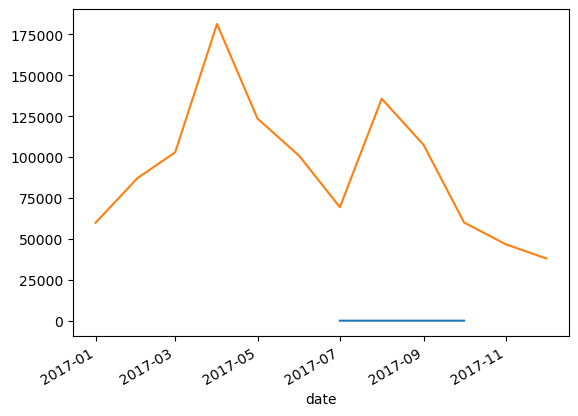

In [26]:
hashtags = ["#missingmaps", "#bloomberg", "visa"]
sql = """

    SELECT lower(hashtag) as hashtag_lower,
    toYear(
        fromUnixTimestamp((changeset_timestamp/1000)::integer)
    ) as year,
    toMonth(
        fromUnixTimestamp((changeset_timestamp/1000)::integer)
    ) as month,
    count(DISTINCT user_id) as users,
    count(DISTINCT changeset_id) as changesets,
    count(DISTINCT contrib_id_text) as contributions
    FROM stats_2
    WHERE ({})
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN '2017-01-01' and '2017-12-31')
    GROUP BY hashtag_lower, year, month
    """.format(' or '.join(['lower(hashtag) like lower(\'{}\')'.format(hashtag.replace("*", "%")) for hashtag in hashtags]))

df = con.query_df(sql)

df["date"] = df.apply(
    lambda x: str(int(x.year)) + "-" + str(int(x.month)) + "-1", axis=1
)
df.date = pd.to_datetime(df.date)
df = df.set_index(pd.DatetimeIndex(df["date"])).drop(["year","month","date"],axis=1)

df = df.sort_index()
display(df.head(5))

df.groupby(["hashtag_lower"])["changesets"].plot()
plt.show()

# Stats for individaul users

## top users by contributions for a hashtag


In [29]:
hashtag = "#MissingMaps"

sql = f"""
    SELECT user_id,
    count( DISTINCT contrib_id_text) as contributions
    FROM stats_2
    WHERE lower(hashtag) ILIKE lower('{hashtag}')
    AND (FROM_UNIXTIME((changeset_timestamp/1000)::integer) BETWEEN  '2017-01-01' and '2017-12-31')
    GROUP BY user_id
    ORDER BY contributions DESC
    """

df = con.query_df(sql)

display(df.head(5))

,user_id,contributions
0,2602222,354665
1,2896303,305158
2,4159996,273077
3,5099490,255870
4,5752603,251500
